In this notebook:
    - station data and normalized temperature evolution data are merged
    - plot evolution by urban-non urban
    - regression by urban-non urban

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time as t
import re
from sklearn import datasets, linear_model
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
import matplotlib.patches as mpatches

In [3]:
#import stations with isUrban flag for selected cols
cols = ['Station ID','Station Name', 'Latitude','Longitude','Elevation (m)', 'isUrban' ]
df_stations = pd.read_csv('Dades/OUTPUT XX Filtered Stations Urban-No Urban.csv', skipinitialspace = True, usecols = cols)
df_stations.head()

,Station ID,Station Name,Latitude,Longitude,Elevation (m),isUrban
0,275,PALMA MALLORCA/SON BONET,39.60000,2.700,45.0,1
1,285,BARCELONA AP EL PRATc,41.29167,2.075,1.6,1
2,22806,SAN FERNANDO,36.30000,-6.100,28.0,0
3,22807,SAN FERNANDO,36.46700,-6.200,29.0,1
4,22808,SAN FERNANDO/CADIZ,36.50000,-6.200,28.0,1


In [4]:
#import dades normalitzades
df = pd.read_csv('Dades/OUTPUT 04 Dades Normalitzades.csv')
df.head()

,Date,Month,Station ID,Temperature (C),Temperature Norm,Temperature Norm Smoothed (ewma),Temperature Norm Smoothed (moving avg),Year,DateISO
0,1951.042,1,275,10.2,0.39,0.390000,-0.91,1951,1951-01-01
1,1952.042,1,275,8.8,-1.01,-0.485000,-0.96,1952,1952-01-01
2,1953.042,1,275,7.7,-2.11,-1.314082,-0.17,1953,1953-01-01
3,1954.042,1,275,8.7,-1.11,-1.220294,-0.17,1954,1954-01-01
4,1955.042,1,275,12.8,2.99,0.605822,-0.39,1955,1955-01-01


In [5]:
#merge data with urban information
df_urban = pd.merge(df,df_stations,how='inner',  on ='Station ID')

In [6]:
df_isUrban_byyear = df_urban.pivot_table(index='Year',columns='isUrban',values = 'Temperature Norm Smoothed (moving avg)',aggfunc='mean')

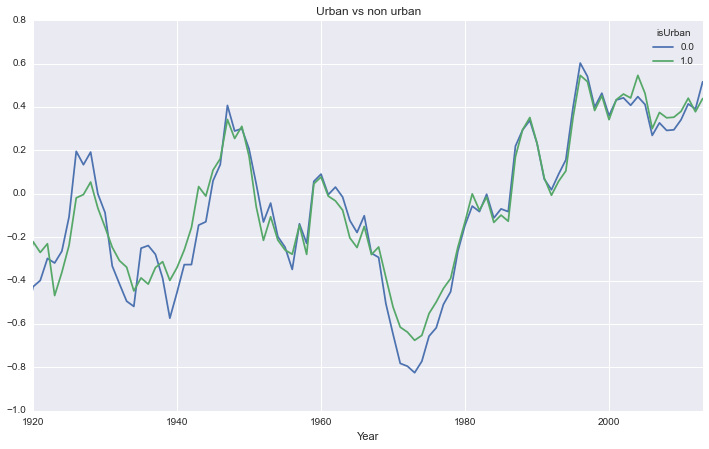

In [7]:
plt.figure
df_isUrban_byyear.plot(xlim=(1920,2013),figsize=(12,7), title='Urban vs non urban')

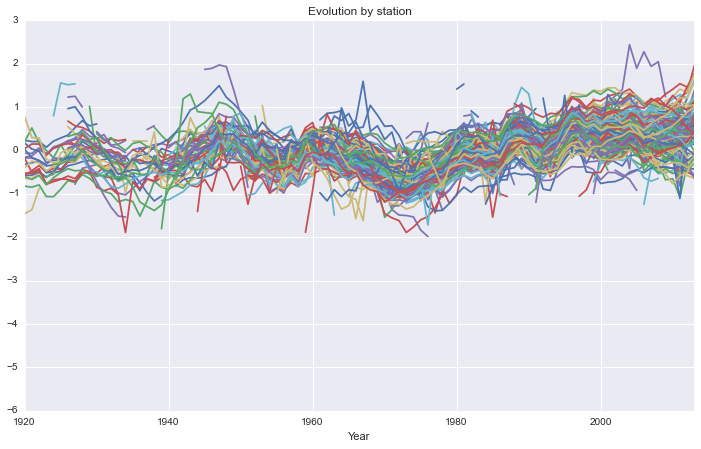

In [8]:
df_station_byyear = df_urban.pivot_table(index='Year',columns=['Station ID'],values = 'Temperature Norm Smoothed (moving avg)',aggfunc='mean')
plt.figure
df_station_byyear.plot(legend=False,xlim=(1920,2013),figsize=(12,7), title='Evolution by station')

#Regression

1) Regression done grouping by year and isUrban before the regression

In [9]:
#get series for Urban and non Urban by year
df_isUrban_byyear_stacked = df_isUrban_byyear.stack()
df_Urban_byYear = df_isUrban_byyear_stacked[:,1]
df_nonUrban_byYear = df_isUrban_byyear_stacked[:,0]

Urban
Coefficient: 0.0059
Residual sum of squares: 0.06
Variance score: 0.38

NON Urban
Coefficient: 0.0057
Residual sum of squares: 0.09
Variance score: 0.29


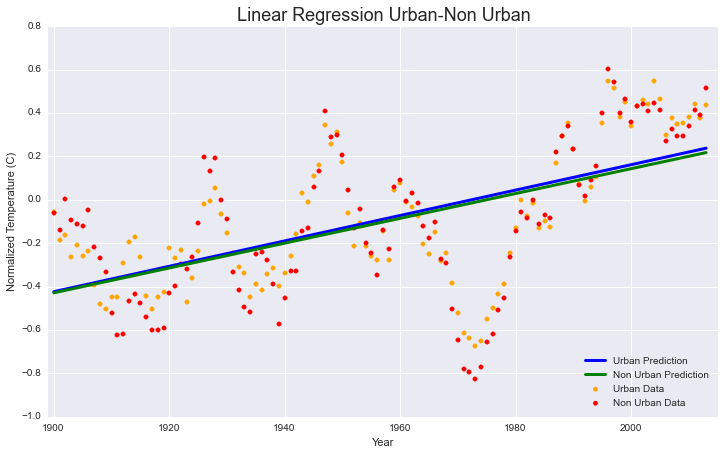

In [10]:
#make a regression for urban and another one for non urban by year average
regr = linear_model.LinearRegression()
Urban_X = pd.DataFrame(df_Urban_byYear.index)
Urban_Y = pd.DataFrame(df_Urban_byYear.values)
regr.fit(Urban_X,Urban_Y)

regr2 = linear_model.LinearRegression()
Non_Urban_X = pd.DataFrame(df_nonUrban_byYear.index)
Non_Urban_Y = pd.DataFrame(df_nonUrban_byYear.values)
regr2.fit(Non_Urban_X,Non_Urban_Y)

# The coefficients
print "Urban"
print 'Coefficient:', round(regr.coef_[0][0],4)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(Urban_X) - Urban_Y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(Urban_X, Urban_Y) )

print "\nNON Urban"
print 'Coefficient:', round(regr2.coef_[0][0],4)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr2.predict(Non_Urban_X) - Non_Urban_Y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr2.score(Non_Urban_X, Non_Urban_Y))

# Plot outputs
plt.figure(figsize=(12,7))
plt.scatter(Urban_X, Urban_Y,  color='orange', label='Urban Data')
plt.plot(Urban_X, regr.predict(Urban_X), color='blue',
         linewidth=3, label='Urban Prediction')

plt.scatter(Non_Urban_X, Non_Urban_Y,  color='red', label = 'Non Urban Data')
plt.plot(Non_Urban_X, regr2.predict(Non_Urban_X), color='green',
         linewidth=3, label = 'Non Urban Prediction')
plt.xlim((1899,2015))
plt.title('Linear Regression Urban-Non Urban', fontsize=18)
plt.legend(loc=4 , scatterpoints = 1)
plt.xlabel('Year')
plt.ylabel('Normalized Temperature (C)')
plt.show()

2) Regression done by Date and station (splitting by isUrban)

In [11]:
df_isurban = df_urban[df_urban.isUrban==1]
df_nonurban = df_urban[df_urban.isUrban==0]

Urban
Coefficients: 0.0077
Residual sum of squares: 0.55
Variance score: 0.07

NON Urban
Coefficients: 0.0084
Residual sum of squares: 0.56
Variance score: 0.07


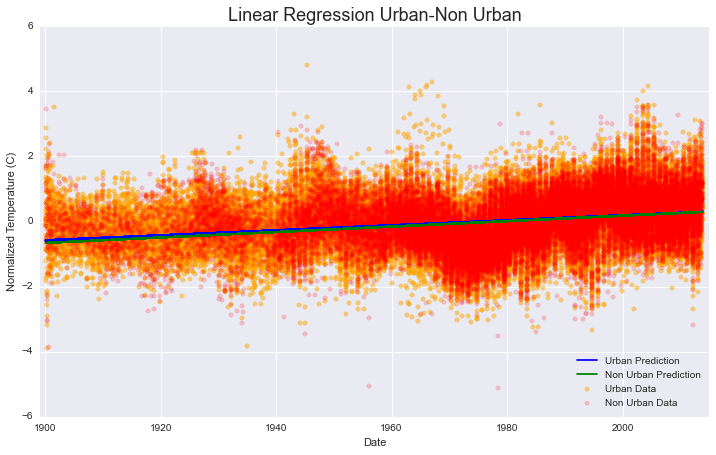

In [12]:
#make a regression for urban and another one for non urban by year average
regr = linear_model.LinearRegression()
Urban_X = pd.DataFrame(df_isurban.Date)
Urban_Y = pd.DataFrame(df_isurban['Temperature Norm Smoothed (moving avg)'])
regr.fit(Urban_X,Urban_Y)

regr2 = linear_model.LinearRegression()
Non_Urban_X = pd.DataFrame(df_nonurban.Date)
Non_Urban_Y = pd.DataFrame(df_nonurban['Temperature Norm Smoothed (moving avg)'])
regr2.fit(Non_Urban_X,Non_Urban_Y)

# The coefficients
print "Urban"
print 'Coefficients:', round(regr.coef_[0][0],4)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(Urban_X) - Urban_Y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(Urban_X, Urban_Y) )

print "\nNON Urban"
print 'Coefficients:', round(regr2.coef_[0][0],4)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr2.predict(Non_Urban_X) - Non_Urban_Y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr2.score(Non_Urban_X, Non_Urban_Y))

# Plot outputs
plt.figure(figsize=(12,7))
plt.scatter(Urban_X, Urban_Y,  color='orange', label='Urban Data', alpha=0.5)
plt.plot(Urban_X, regr.predict(Urban_X), color='blue',
          label='Urban Prediction')

plt.scatter(Non_Urban_X, Non_Urban_Y,  color='red', label = 'Non Urban Data',alpha=0.2)
plt.plot(Non_Urban_X, regr2.predict(Non_Urban_X), color='green',
          label = 'Non Urban Prediction')
plt.xlim((1899,2015))
plt.title('Linear Regression Urban-Non Urban', fontsize=18)
plt.legend(loc=4 , scatterpoints = 1)
plt.xlabel('Date')
plt.ylabel('Normalized Temperature (C)')
plt.show()

3) Regression done by Date and station (splitting by isUrban) for Year>1970

In [13]:
df_urban70 = df_urban[df_urban.Year>1969]
df_isurban = df_urban70[df_urban70.isUrban==1]
df_nonurban = df_urban70[df_urban70.isUrban==0]

In [14]:
#make a regression for urban and another one for non urban by year average
regr = linear_model.LinearRegression()
Urban_X = pd.DataFrame(df_isurban.Date)
Urban_Y = pd.DataFrame(df_isurban['Temperature Norm Smoothed (moving avg)'])
regr.fit(Urban_X,Urban_Y)

regr2 = linear_model.LinearRegression()
Non_Urban_X = pd.DataFrame(df_nonurban.Date)
Non_Urban_Y = pd.DataFrame(df_nonurban['Temperature Norm Smoothed (moving avg)'])
regr2.fit(Non_Urban_X,Non_Urban_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Urban
Coefficients: 0.0269
Residual sum of squares: 0.52
Variance score: 0.18

NON Urban
Coefficients: 0.0291
Residual sum of squares: 0.52
Variance score: 0.20


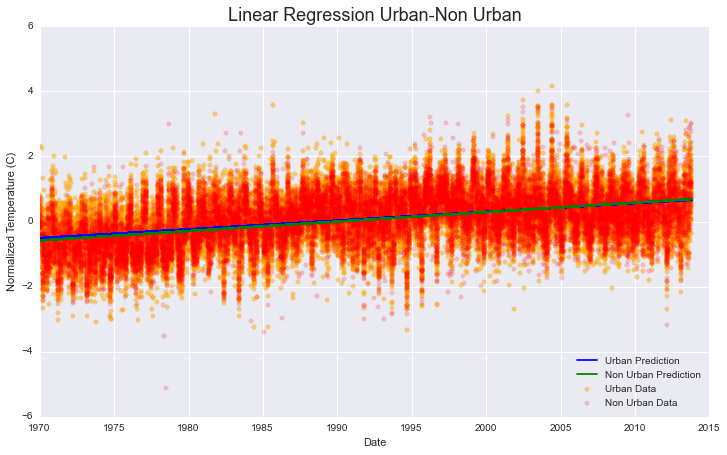

In [15]:
# The coefficients
print "Urban"
print 'Coefficients:', round(regr.coef_[0][0],4)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(Urban_X) - Urban_Y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(Urban_X, Urban_Y) )

print "\nNON Urban"
print 'Coefficients:', round(regr2.coef_[0][0],4)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr2.predict(Non_Urban_X) - Non_Urban_Y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr2.score(Non_Urban_X, Non_Urban_Y))

# Plot outputs
plt.figure(figsize=(12,7))
plt.scatter(Urban_X, Urban_Y,  color='orange', label='Urban Data', alpha=0.5)
plt.plot(Urban_X, regr.predict(Urban_X), color='blue',
          label='Urban Prediction')

plt.scatter(Non_Urban_X, Non_Urban_Y,  color='red', label = 'Non Urban Data',alpha=0.2)
plt.plot(Non_Urban_X, regr2.predict(Non_Urban_X), color='green',
          label = 'Non Urban Prediction')
plt.xlim((1970,2015))
plt.title('Linear Regression Urban-Non Urban', fontsize=18)
plt.legend(loc=4 , scatterpoints = 1)
plt.xlabel('Date')
plt.ylabel('Normalized Temperature (C)')
plt.show()

4) Regression done by Date and station (splitting by isUrban) with seaborn

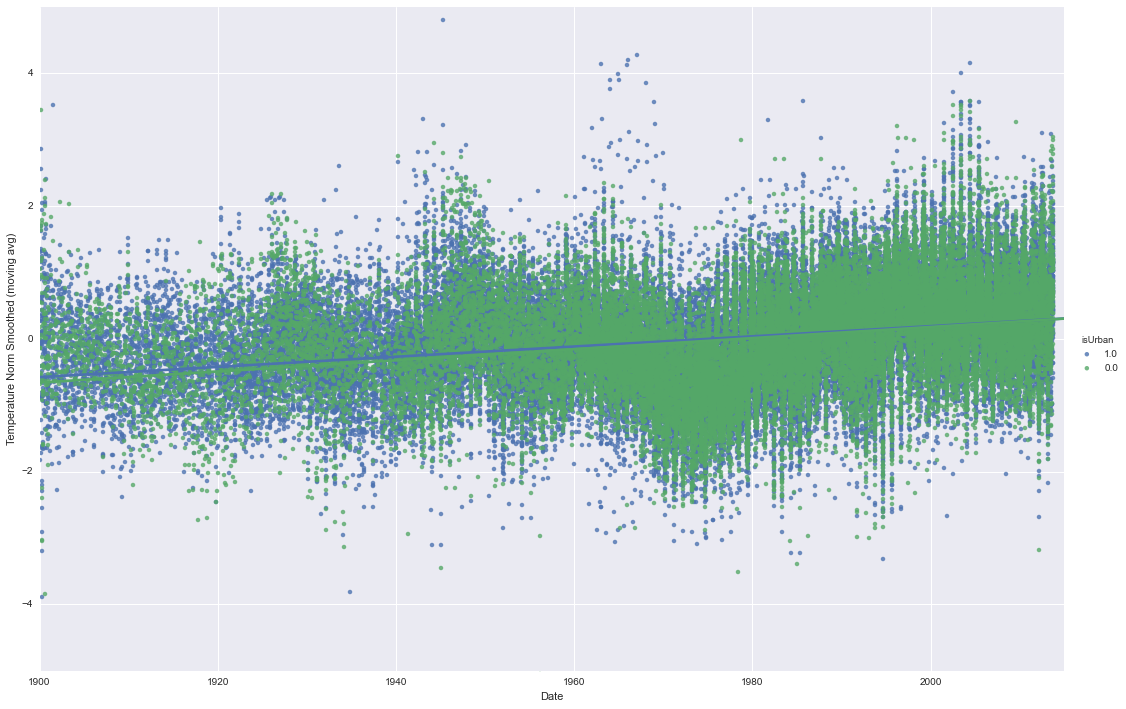

In [16]:
lm = sns.lmplot(x="Date", y="Temperature Norm Smoothed (moving avg)", hue="isUrban", data=df_urban, size = 10,aspect=1.5).set(xlim=(1900,2015),ylim=(-5,5))

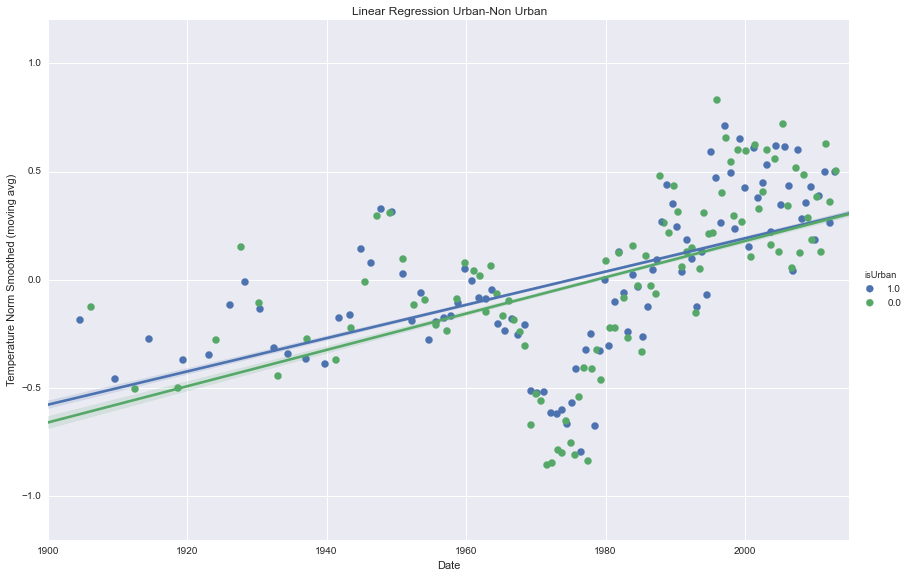

In [17]:
#x_bins t'agrupa les x del plot perquè quedi més visual / x_ci ajusta l'ombra de la regressió amb l'interval de confiança que dones
lm = sns.lmplot(x="Date", y="Temperature Norm Smoothed (moving avg)", hue="isUrban", data=df_urban, size = 8, x_bins = 100, x_ci = 0.95,aspect=1.5).set(xlim=(1900,2015),ylim=(-1.2,1.2),title='Linear Regression Urban-Non Urban')

A regression with isUrban and its interaction with Date is done in order to check the significancy of the difference seen before.
Results show that it's siginifant, but looking at the distribution it does not look like that. Mainly because the distribution in time is very uneven, specially in the first 40 years, where the  slope is more affected because date is further from it's mean. Also, we can see a big valley around the 70s that could show longer trends that we are not able to see in this 100-year graph 

Let's check in more detail the distribution and repeat this step for years with more samples.

In [18]:
X_stats = df_urban['Temperature Norm Smoothed (moving avg)']
Y_stats = df_urban[['Date','isUrban']]
Y_stats ['Date*isUrban'] = df_urban['Date']*df_urban['isUrban']
Y_stats = sm.tools.tools.add_constant(Y_stats,prepend=False)

mod = sm.regression.linear_model.OLS(X_stats, Y_stats)
res = mod.fit()
print res.summary()

                                      OLS Regression Results                                      
Dep. Variable:     Temperature Norm Smoothed (moving avg)   R-squared:                       0.072
Model:                                                OLS   Adj. R-squared:                  0.072
Method:                                     Least Squares   F-statistic:                     2278.
Date:                                    Tue, 01 Mar 2016   Prob (F-statistic):               0.00
Time:                                            08:09:17   Log-Likelihood:                -99448.
No. Observations:                                   88370   AIC:                         1.989e+05
Df Residuals:                                       88366   BIC:                         1.989e+05
Df Model:                                               3                                         
Covariance Type:                                nonrobust                                         
          

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


5) Checking distribution by year and Temperature

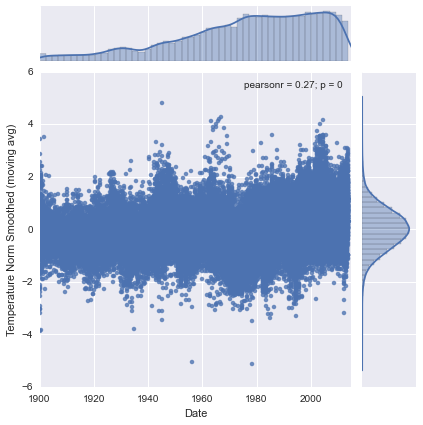

In [19]:
sns.jointplot(x="Date", y="Temperature Norm Smoothed (moving avg)", data=df_urban, kind="reg",xlim=(1900,2015))

6) Regression done by Date and station (splitting by isUrban) with seaborn for year > 1970

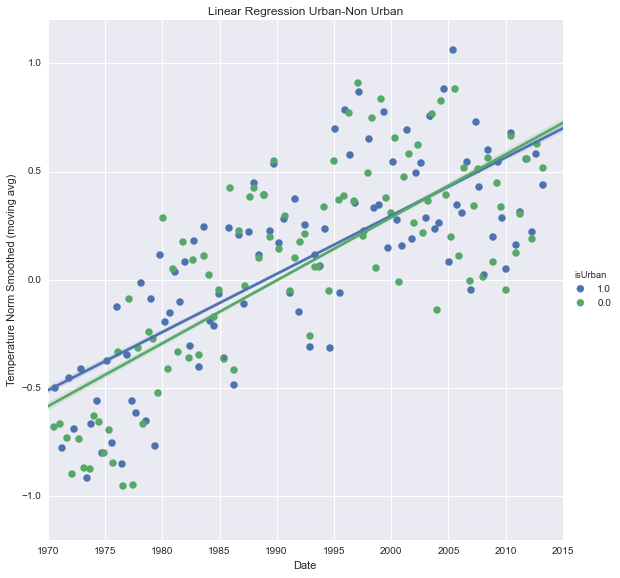

In [20]:
#x_bins t'agrupa les x del plot perquè quedi més visual / x_ci ajusta l'ombra de la regressió amb l'interval de confiança que dones
lm = sns.lmplot(x="Date", y="Temperature Norm Smoothed (moving avg)", hue="isUrban", data=df_urban[df_urban.Year>1969], size = 8, x_bins = 100, x_ci = 0.95).set(xlim=(1970,2015),ylim=(-1.2,1.2),title='Linear Regression Urban-Non Urban')

A regression with isUrban and its interaction with Date is done in order to check the significancy of the difference seen before for years greater than 1970. Again, it's significantly different. But, it's easy to see that during the first 7 years all Urban samples have higher temperatures than non urban ones, even though distribution in al other years is much more mixed. Let's repeat this regression starting on the 1975 to see if these first 5 years values (which have a big effect in the regression) change the outcome.

In [21]:
df_urban70=df_urban[df_urban.Year>1969]

X_stats = df_urban70['Temperature Norm Smoothed (moving avg)']
Y_stats = df_urban70[['Date','isUrban']]
Y_stats ['Date*isUrban'] = df_urban70['Date']*df_urban70['isUrban']
Y_stats = sm.tools.tools.add_constant(Y_stats,prepend=False)

mod = sm.regression.linear_model.OLS(X_stats, Y_stats)
res = mod.fit()
print res.summary()

                                      OLS Regression Results                                      
Dep. Variable:     Temperature Norm Smoothed (moving avg)   R-squared:                       0.186
Model:                                                OLS   Adj. R-squared:                  0.186
Method:                                     Least Squares   F-statistic:                     4373.
Date:                                    Tue, 01 Mar 2016   Prob (F-statistic):               0.00
Time:                                            08:09:40   Log-Likelihood:                -62514.
No. Observations:                                   57255   AIC:                         1.250e+05
Df Residuals:                                       57251   BIC:                         1.251e+05
Df Model:                                               3                                         
Covariance Type:                                nonrobust                                         
          

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A regression with isUrban and its interaction with Date is done in order to check the significancy of the difference seen before for years greater than 1975. Unexpectedly (or not), urban and not urban are not significantly different when data from years greater than 1975 is taken. 

In [23]:
df_urban75=df_urban[df_urban.Year>1974]

X_stats = df_urban75['Temperature Norm Smoothed (moving avg)']
Y_stats = df_urban75[['Date','isUrban']]
Y_stats ['Date*isUrban'] = df_urban75['Date']*df_urban75['isUrban']
Y_stats = sm.tools.tools.add_constant(Y_stats,prepend=False)

mod = sm.regression.linear_model.OLS(X_stats, Y_stats)
res = mod.fit()
print res.summary()

                                      OLS Regression Results                                      
Dep. Variable:     Temperature Norm Smoothed (moving avg)   R-squared:                       0.118
Model:                                                OLS   Adj. R-squared:                  0.118
Method:                                     Least Squares   F-statistic:                     2310.
Date:                                    Tue, 01 Mar 2016   Prob (F-statistic):               0.00
Time:                                            08:14:27   Log-Likelihood:                -56266.
No. Observations:                                   51633   AIC:                         1.125e+05
Df Residuals:                                       51629   BIC:                         1.126e+05
Df Model:                                               3                                         
Covariance Type:                                nonrobust                                         
          

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


After doing regressions in different time windows we can conclude that there is no significant difference between urban and non urban temperature increase. Now, let's see if the temperature increase is significant:

In [24]:
X_stats = df_urban['Temperature Norm Smoothed (moving avg)']
Y_stats = df_urban[['Date']]
Y_stats = sm.tools.tools.add_constant(Y_stats,prepend=False)

mod = sm.regression.linear_model.OLS(X_stats, Y_stats)
res = mod.fit()
print res.summary()

                                      OLS Regression Results                                      
Dep. Variable:     Temperature Norm Smoothed (moving avg)   R-squared:                       0.071
Model:                                                OLS   Adj. R-squared:                  0.071
Method:                                     Least Squares   F-statistic:                     6788.
Date:                                    Tue, 01 Mar 2016   Prob (F-statistic):               0.00
Time:                                            08:20:03   Log-Likelihood:                -99469.
No. Observations:                                   88370   AIC:                         1.989e+05
Df Residuals:                                       88368   BIC:                         1.990e+05
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
          

Over the last 100 years, there is a significant increase of 0.7ºC/100 years. Which is of 2.7ºC/100 years if data beggining at 1970 is taken:

In [25]:
df_urban70=df_urban[df_urban.Year>1969]

X_stats = df_urban70['Temperature Norm Smoothed (moving avg)']
Y_stats = df_urban70['Date']
Y_stats = sm.tools.tools.add_constant(Y_stats,prepend=False)

mod = sm.regression.linear_model.OLS(X_stats, Y_stats)
res = mod.fit()
print res.summary()

                                      OLS Regression Results                                      
Dep. Variable:     Temperature Norm Smoothed (moving avg)   R-squared:                       0.186
Model:                                                OLS   Adj. R-squared:                  0.186
Method:                                     Least Squares   F-statistic:                 1.308e+04
Date:                                    Tue, 01 Mar 2016   Prob (F-statistic):               0.00
Time:                                            08:22:35   Log-Likelihood:                -62532.
No. Observations:                                   57255   AIC:                         1.251e+05
Df Residuals:                                       57253   BIC:                         1.251e+05
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
          